In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os, re, glob,sys
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.models import load_model
import numpy as np

np.random.seed(777)


Using TensorFlow backend.


In [2]:
print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

Python version :  3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
TensorFlow version :  1.13.1
Keras version :  2.2.4
OpenCV version :  4.1.2


In [3]:
dir_path = './extracted_images_v2/'
categories =os.listdir(dir_path+"train")
num_classes = len(categories)

In [4]:
train_dir = os.path.join(dir_path, 'train')
validation_dir = os.path.join(dir_path, 'validation')
test_dir = os.path.join(dir_path, 'test')

In [5]:
image_w = 45
image_h = 45
X_train = []
Y_train = []


In [6]:
"""
for idex, categorie in enumerate(categories):
    label = [0 for i in range(num_classes)]
    label[idex] = 1
    image_dir = dir_path + categorie + '/'
    print(image_dir)
  
    for top, dir, f in os.walk(image_dir):
        for filename in f:
            print(image_dir+filename)
            img = cv2.imread(image_dir+filename)
            img = cv2.resize(img, None, fx=image_w/img.shape[1], fy=image_h/img.shape[0])
            X_train.append(img/256)
            Y_train.append(label)
            
"""

"\nfor idex, categorie in enumerate(categories):\n    label = [0 for i in range(num_classes)]\n    label[idex] = 1\n    image_dir = dir_path + categorie + '/'\n    print(image_dir)\n  \n    for top, dir, f in os.walk(image_dir):\n        for filename in f:\n            print(image_dir+filename)\n            img = cv2.imread(image_dir+filename)\n            img = cv2.resize(img, None, fx=image_w/img.shape[1], fy=image_h/img.shape[0])\n            X_train.append(img/256)\n            Y_train.append(label)\n            \n"

In [7]:
#X = np.array(X_train)
#Y = np.array(Y_train)

In [8]:
#X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
#xy = (X_train, X_test, Y_train, Y_test)
 
#np.save("./keras_1.npy", xy)

In [9]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen=ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=10, #회전각 10도
    width_shift_range=0.1, #상하로 10% 이동
    height_shift_range=0.1, #좌우로 10% 이동
    shear_range=0.1, #0.1 라디안 내외 시계반대방향 변형
    zoom_range=0.2) #축소,확대


train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(45,45),
    batch_size=100,
    class_mode='categorical')
#    color_mode = 'grayscale')

validation_generator=test_datagen.flow_from_directory(
    validation_dir,
    target_size=(45,45),
    batch_size=100,
    class_mode='categorical')
#    color_mode = 'grayscale')

test_generator=test_datagen.flow_from_directory(
    validation_dir,
    target_size=(45,45),
    batch_size=100,
    class_mode='categorical')
#    color_mode = 'grayscale')

Found 95481 images belonging to 46 classes.
Found 31842 images belonging to 46 classes.
Found 31842 images belonging to 46 classes.


In [10]:
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from keras.layers import Flatten, Convolution2D, MaxPooling2D
from keras.models import load_model

In [11]:
from keras import models,layers

In [12]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid

def attention_module(net):
    net = cbam_block(net)
    
    return net

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature._keras_shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature._keras_shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool._keras_shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool._keras_shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat._keras_shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature._keras_shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

In [13]:
inp = Input((45,45,3))

x = Conv2D(256, (3,3), activation='relu', padding='valid', name='block1_conv2')(inp)
x = attention_module(x)
x = MaxPooling2D((2, 2),  name='block1_pool')(x)

x = Conv2D(128, (3,3), activation='relu', padding='valid', name='block2_conv2')(x)
x = attention_module(x)
x = MaxPooling2D((2, 2),  name='block2_pool')(x)

x = Conv2D(64, (3,3), activation='relu', padding='valid', name='block3_conv3')(x)
x = attention_module(x)
x = MaxPooling2D((2, 2),  name='block3_pool')(x)

x = Flatten()(x)
x = Dense(128, activation='relu', name='dense1')(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation='softmax', name='dense2')(x)

model = Model(inputs=inp, outputs=out)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
"""
model=models.Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(45,45,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
#model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))
"""


"""
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(45,45,3)))
model.add(layers.Flatten())
model.add(layers.Dense(2025, activation='relu'))
model.add(layers.Dropout(0.2),)
model.add(layers.Dense(46, activation='softmax'))
model.summary()
"""

"\nmodel.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(45,45,3)))\nmodel.add(layers.Flatten())\nmodel.add(layers.Dense(2025, activation='relu'))\nmodel.add(layers.Dropout(0.2),)\nmodel.add(layers.Dense(46, activation='softmax'))\nmodel.summary()\n"

In [15]:
from keras import optimizers

In [16]:
#model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

In [17]:
#모델 시각화
"""
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
"""

"\nfrom IPython.display import SVG\nfrom keras.utils.vis_utils import model_to_dot\n\n%matplotlib inline\n\nSVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))\n"

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

In [19]:
#model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
history = model.fit_generator(train_generator, 
    epochs=200,#총 30번
    steps_per_epoch=100, #에폭 당 스텝 수, 즉 배치size가 10이므로 1000개씩만 돌리는 거임
    validation_data=validation_generator, #검증용 데이터로 평가
    validation_steps=10,  #검증용 데이터는 10개(배치) * 10번 즉 100번만
    callbacks=[early_stopping]
                             
)
model.save('model_keras_cbam.h5')

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/200
100/100 [==============================] - 656s 7s/step - loss: 3.0679 - acc: 0.1765 - val_loss: 2.7913 - val_acc: 0.2130
Epoch 2/200
100/100 [==============================] - 665s 7s/step - loss: 2.4705 - acc: 0.3418 - val_loss: 2.0346 - val_acc: 0.4260
Epoch 3/200
100/100 [==============================] - 671s 7s/step - loss: 1.6980 - acc: 0.5835 - val_loss: 1.1898 - val_acc: 0.7010
Epoch 4/200
100/100 [==============================] - 650s 7s/step - loss: 1.2918 - acc: 0.6715 - val_loss: 1.0566 - val_acc: 0.7170
Epoch 5/200
100/100 [==============================] - 657s 7s/step - loss: 1.0643 - acc: 0.7191 - val_loss: 0.7095 - val_acc: 0.7850
Epoch 6/200
100/100 [==============================] - 652s 7s/step - loss: 0.9088 - acc: 0.7597 - val_loss: 0.5216 - val_acc: 0.8510
Epoch 7/200
100/100 [==============================] - 650s 7s/step - 

Epoch 58/200
100/100 [==============================] - 661s 7s/step - loss: 0.2703 - acc: 0.9255 - val_loss: 0.1139 - val_acc: 0.9690
Epoch 59/200
100/100 [==============================] - 672s 7s/step - loss: 0.2856 - acc: 0.9226 - val_loss: 0.1354 - val_acc: 0.9610
Epoch 60/200
100/100 [==============================] - 667s 7s/step - loss: 0.2776 - acc: 0.9218 - val_loss: 0.1476 - val_acc: 0.9540
Epoch 61/200
100/100 [==============================] - 666s 7s/step - loss: 0.2624 - acc: 0.9255 - val_loss: 0.1740 - val_acc: 0.9470
Epoch 62/200
100/100 [==============================] - 688s 7s/step - loss: 0.2685 - acc: 0.9239 - val_loss: 0.1734 - val_acc: 0.9560
Epoch 63/200
100/100 [==============================] - 663s 7s/step - loss: 0.2642 - acc: 0.9241 - val_loss: 0.1292 - val_acc: 0.9690
Epoch 64/200
100/100 [==============================] - 621s 6s/step - loss: 0.2585 - acc: 0.9281 - val_loss: 0.1775 - val_acc: 0.9554
Epoch 65/200
100/100 [==============================] -

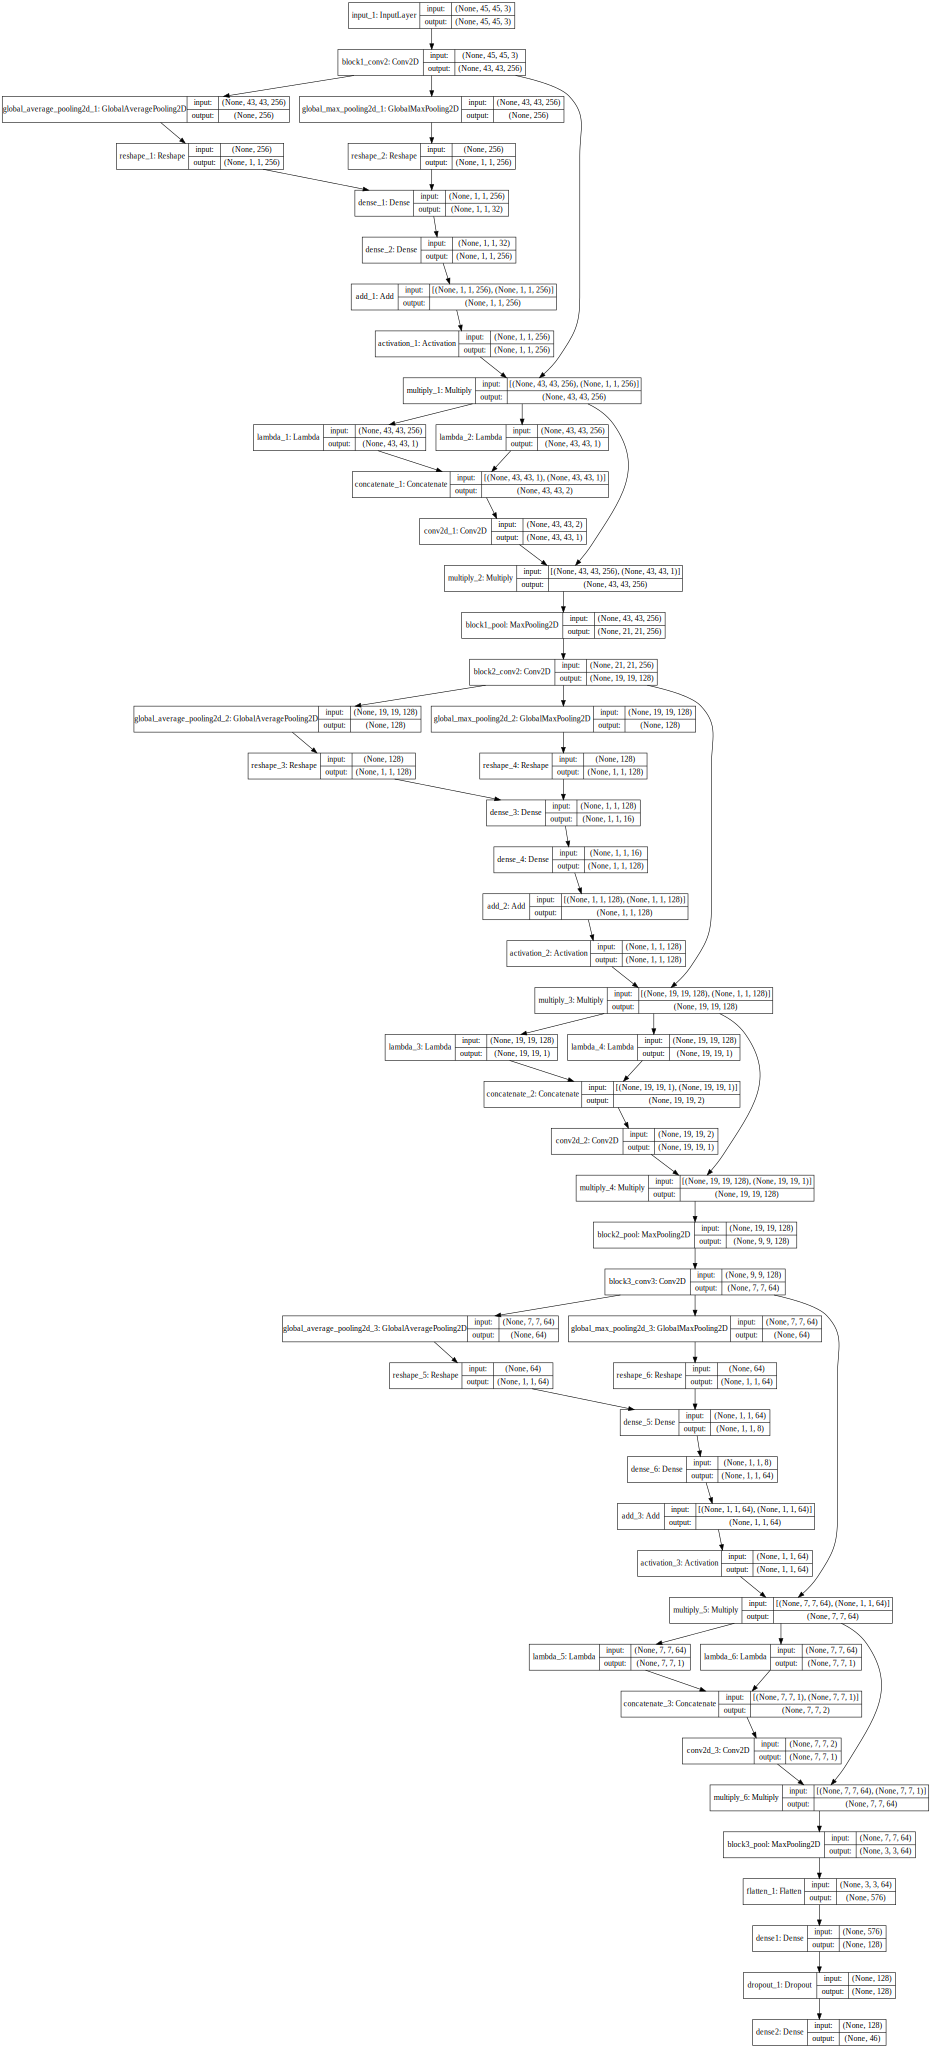

In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

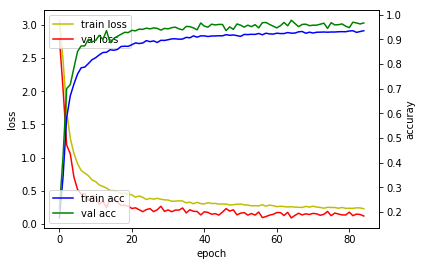

In [21]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [22]:
# 모델 예측하기
print("-- Predict --")

output = model.predict_generator(
            test_generator, 
            steps = 5)

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})



-- Predict --


In [23]:
print(output[0])

[0.000 0.000 0.990 0.000 0.008 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.002
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]


In [24]:
scores = model.evaluate_generator(
            test_generator, 
            steps = 5)
model.save_weights('handwritten_cbam_checkpoint')
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))


acc: 95.80%


#OpenCV 이용, 실시간 인식

step 1. 단순 이미지 영역 나누기